In [2]:
# Comments about the model

# Since I had not used a model like that before I used the tutorial notebook as a base.
# When I first started working on the model I could not get it working (problem with a model size)
# I found the answer in the comment section of the Tutorial notebook and applied it. 

# I first ran this on my own computer and got good results when increasing the number of epochs 
# (but I had to decrease the batch size because otherwise everything crashed)
# When I finally tried to run it in Kaggle I realized that the model was overfitted on the dataset and that's why
# results on my computer differed so much from the ones in Kaggle

# I searched for ways to increase the accuracy of my model (thank you ChatGPT) but ran out of time an could not 
# implement these changes (I had to run the code in Kaggle to be sure the changes are working since batch size 
# had to be 8 in my computer)

# I found the following ways:
# Increase training data by shuffling the data (I tried that but it did not increase the accuracy)
# Increase training data by Synonyme replacement (using a synonyme dictionary)
# Translating all the sentences to English 

# In addition I found some articles about batch size vs learning rate where they found out that on their dataset
# learning rate of 0.00017 was the best so I tried that

# The learning rate I got from Kaggle was 0.34706


In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/contradictory-my-dear-watson/sample_submission.csv
/kaggle/input/contradictory-my-dear-watson/train.csv
/kaggle/input/contradictory-my-dear-watson/test.csv


In [2]:
# Lets install transformers 

!pip install transformers

from transformers import BertTokenizer, TFBertModel
import matplotlib.pyplot as plt
import tensorflow as tf


In [3]:
os.environ["WANDB_API_KEY"] = "0" ## to silence warning

try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except ValueError:
    strategy = tf.distribute.get_strategy() # for CPU and single GPU
    print('Number of replicas:', strategy.num_replicas_in_sync)

In [4]:
# Let's read in train file
train = pd.read_csv("../input/contradictory-my-dear-watson/train.csv")

In [5]:
# Lets see how does the table look like
train.head()

,id,premise,hypothesis,lang_abv,language,label
0,5130fd2cb5,and these comments were considered in formulat...,The rules developed in the interim were put to...,en,English,0
1,5b72532a0b,These are issues that we wrestle with in pract...,Practice groups are not permitted to work on t...,en,English,2
2,3931fbe82a,Des petites choses comme celles-là font une di...,J'essayais d'accomplir quelque chose.,fr,French,0
3,5622f0c60b,you know they can't really defend themselves l...,They can't defend themselves because of their ...,en,English,0
4,86aaa48b45,ในการเล่นบทบาทสมมุติก็เช่นกัน โอกาสที่จะได้แสด...,เด็กสามารถเห็นได้ว่าชาติพันธุ์แตกต่างกันอย่างไร,th,Thai,1


In [6]:
# Lets lowercase everything
train = train.applymap(lambda x: x.lower() if isinstance(x, str) else x)
train.head()

,id,premise,hypothesis,lang_abv,language,label
0,5130fd2cb5,and these comments were considered in formulat...,the rules developed in the interim were put to...,en,english,0
1,5b72532a0b,these are issues that we wrestle with in pract...,practice groups are not permitted to work on t...,en,english,2
2,3931fbe82a,des petites choses comme celles-là font une di...,j'essayais d'accomplir quelque chose.,fr,french,0
3,5622f0c60b,you know they can't really defend themselves l...,they can't defend themselves because of their ...,en,english,0
4,86aaa48b45,ในการเล่นบทบาทสมมุติก็เช่นกัน โอกาสที่จะได้แสด...,เด็กสามารถเห็นได้ว่าชาติพันธุ์แตกต่างกันอย่างไร,th,thai,1


In [7]:
# Before going on with the work we should see if there is a need for clearing the data
train.describe()

,label
count,12120.000000
mean,0.990759
std,0.824523
min,0.000000
25%,0.000000
50%,1.000000
75%,2.000000
max,2.000000


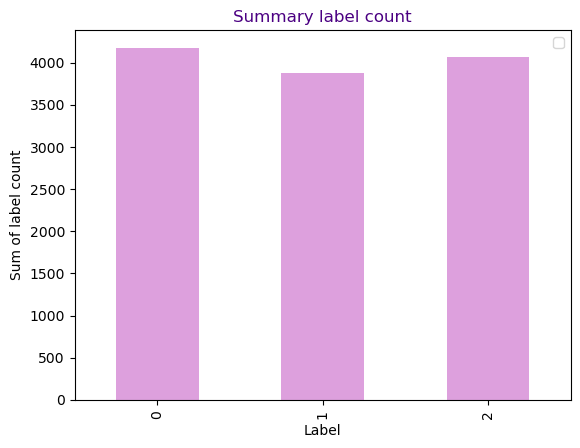

In [8]:
# Since the only numeric value is label that field is described
# I would like to know how are the labels distributed
train.groupby('label').count().plot.bar(color='plum')
plt.legend([], loc='best')
plt.ylabel('Sum of label count')
plt.xlabel('Label')
plt.title('Summary label count', color='indigo')
bars=('0','1','2')
y_pos = np.arange(len(bars))
plt.xticks(y_pos, bars)
plt.show()

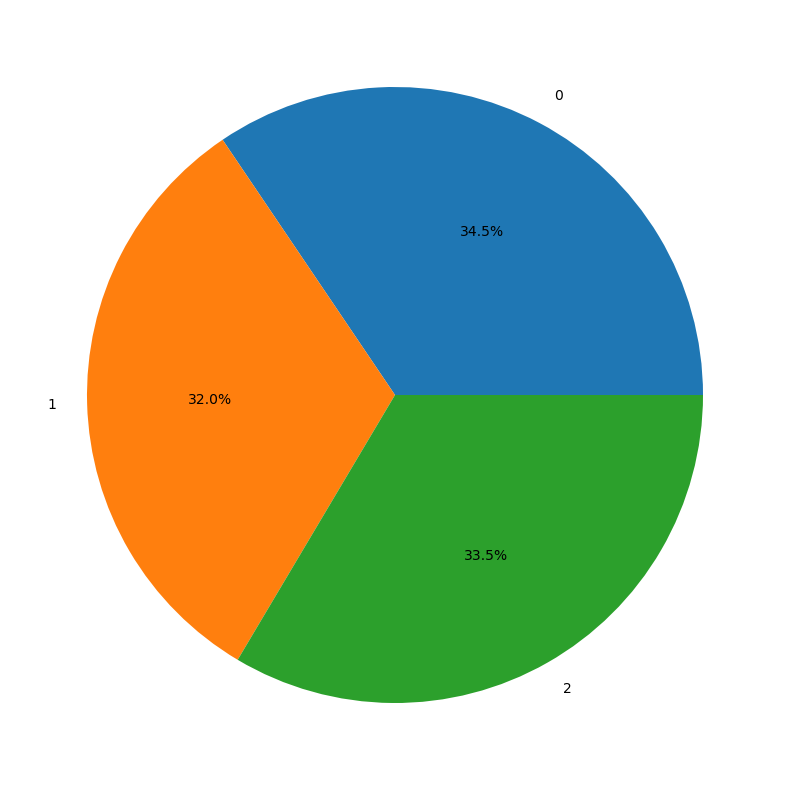

In [9]:
# We can see that the distribution is quite even, lets see that on a pie chart which gives us a better overview
labels, frequencies = np.unique(train.label.values, return_counts = True)

plt.figure(figsize = (10,10))
plt.pie(frequencies,labels = labels, autopct = '%1.1f%%')
plt.show()

In [10]:
# We have explored the data, lets try to find if there is any need for clearing it up
train.shape

(12120, 6)

In [11]:
# We have 12120 rows and 6 columns
# Lets see if there are any empty fields
missing = train.isnull().values.any()
display(missing)

False

In [12]:
# We found out that there are no missing fields

# If there are any duplicates we should remove them
train = train.drop_duplicates(subset=['premise', 'hypothesis']).sample(frac=1, random_state=42, ignore_index=True)
train.shape

(12120, 6)

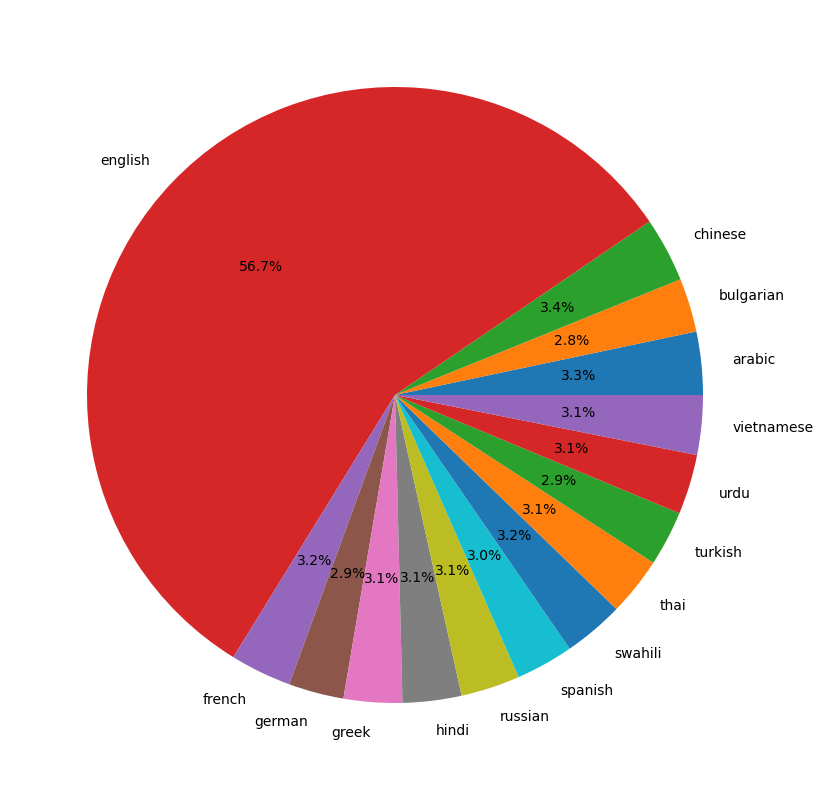

In [13]:
# Since the size of train remains the same there were no duplicates
# How are the languages distributed

labels, frequencies = np.unique(train.language.values, return_counts = True)

plt.figure(figsize = (10,10))
plt.pie(frequencies,labels = labels, autopct = '%1.1f%%')
plt.show()

In [14]:
# In order to improve my accuracy I try to mix it up a bit 

# shuffle the rows in the dataframe
shuffled_train = train.sample(frac=1).reset_index(drop=True)
shuffled_train.head()


,id,premise,hypothesis,lang_abv,language,label
0,9426660470,it was stated that auditors frequently leave t...,auditors get paid more after they leave the pr...,en,english,1
1,da6a08bfbe,برینشاہ کا خیال ہے کہ جراحی کے خاندان کے دورے ...,فیملی کے دورے جرھا کے اتحاد کا کی بنیادی وجہ ہیں۔,ur,urdu,2
2,63d5db46ed,"the average mls ticket costs a mere $13, one-t...",the average cost was lower because the mls is ...,en,english,1
3,5409d53c65,"strom thurmond , r-s.c., celebrated his 95 th ...","on his 85 birthday, strom thurmond announced h...",en,english,2
4,d8f0dd7e17,"en el contexto de la música popular mexicana, ...",las rancheras son canciones de amor cantadas p...,es,spanish,0


In [ ]:
# This looks different to the one imported before

In [15]:
# Lets start with BERT
# We need multilingual because there are several different languages present in the dataset

model_name = 'bert-base-multilingual-cased'
tokenizer = BertTokenizer.from_pretrained(model_name)

In [16]:
# Define encoding

def encode_sentence(s):
   tokens = list(tokenizer.tokenize(s))
   tokens.append('[SEP]')
   return tokenizer.convert_tokens_to_ids(tokens)

In [17]:
# BERT encoder 

def bert_encode(hypotheses, premises, tokenizer, max_length = 50):
    x = [h + ' [SEP] ' + p for h, p in zip(np.array(hypotheses), np.array(premises))]
    x = tokenizer(x, padding=True, truncation=True, max_length=max_length)
   
    num_examples = len(hypotheses)
  
    sentence1 = tf.ragged.constant([
    encode_sentence(s)
        for s in np.array(hypotheses)])
    sentence2 = tf.ragged.constant([
      encode_sentence(s)
        for s in np.array(premises)])

    cls = [tokenizer.convert_tokens_to_ids(['[CLS]'])]*sentence1.shape[0]
    input_word_ids = tf.concat([cls, sentence1, sentence2], axis=-1)

    input_mask = tf.ones_like(input_word_ids).to_tensor()

    type_cls = tf.zeros_like(cls)
    type_s1 = tf.zeros_like(sentence1)
    type_s2 = tf.ones_like(sentence2)
    input_type_ids = tf.concat(
      [type_cls, type_s1, type_s2], axis=-1).to_tensor()

    inputs = {
          'input_word_ids':tf.ragged.constant(x['input_ids']).to_tensor(),
          'input_mask': tf.ragged.constant(x['attention_mask']).to_tensor(),
          'input_type_ids': tf.ragged.constant(x['token_type_ids']).to_tensor()}

    return inputs

In [18]:
# Lets use BERT encoder on our data

train_input = bert_encode(train.premise.values, train.hypothesis.values, tokenizer)
train_input_shuffled = bert_encode(shuffled_train.premise.values, shuffled_train.hypothesis.values, tokenizer)


In [19]:
# Define the model

max_len = 50

def build_model():
    
    # TPU management
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
    
    bert_encoder = TFBertModel.from_pretrained(model_name)
    input_word_ids = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    input_mask = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="input_mask")
    input_type_ids = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="input_type_ids")
    
    # We need embedding because I had some problems with size afterwards
    
    embedding = bert_encoder([input_word_ids, input_mask, input_type_ids])[0]
    output = tf.keras.layers.Dense(3, activation='softmax')(embedding[:,0,:])
    
    model = tf.keras.Model(inputs=[input_word_ids, input_mask, input_type_ids], outputs=output)
    model.compile(tf.keras.optimizers.Adam(lr=0.00017), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    
    return model

In [20]:
# Lets build the model and display a summary
with strategy.scope():
    model = build_model()
    model.summary()


Some layers from the model checkpoint at bert-base-multilingual-cased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-multilingual-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_word_ids (InputLayer)    [(None, 50)]         0           []                               
                                                                                                  
 input_mask (InputLayer)        [(None, 50)]         0           []                               
                                                                                                  
 input_type_ids (InputLayer)    [(None, 50)]         0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  177853440   ['input_word_ids[0][0]',         
                                thPoolingAndCrossAt               'input_mask[0][0]',         

In [21]:
# Lets train the model with original train data
model.fit(train_input, train.label.values, epochs = 4, verbose = 1, batch_size = 64, validation_split = 0.2)


Epoch 1/4
152/152 [==============================] - 155s 504ms/step - loss: 1.2826 - accuracy: 0.3293 - val_loss: 1.1160 - val_accuracy: 0.3362
Epoch 2/4
152/152 [==============================] - 12s 77ms/step - loss: 1.1210 - accuracy: 0.3310 - val_loss: 1.1468 - val_accuracy: 0.3531
Epoch 3/4
152/152 [==============================] - 12s 76ms/step - loss: 1.1195 - accuracy: 0.3292 - val_loss: 1.1391 - val_accuracy: 0.3531
Epoch 4/4
152/152 [==============================] - 12s 76ms/step - loss: 1.1112 - accuracy: 0.3380 - val_loss: 1.1051 - val_accuracy: 0.3106


In [22]:
# Lets train the model with shuffled train data
model.fit(train_input_shuffled, shuffled_train.label.values, epochs = 4, verbose = 1, batch_size = 64, validation_split = 0.2)


Epoch 1/4
152/152 [==============================] - 12s 78ms/step - loss: 1.1090 - accuracy: 0.3369 - val_loss: 1.1382 - val_accuracy: 0.3346
Epoch 2/4
152/152 [==============================] - 12s 77ms/step - loss: 1.1121 - accuracy: 0.3322 - val_loss: 1.1329 - val_accuracy: 0.3073
Epoch 3/4
152/152 [==============================] - 12s 78ms/step - loss: 1.1125 - accuracy: 0.3425 - val_loss: 1.1079 - val_accuracy: 0.3346
Epoch 4/4
152/152 [==============================] - 12s 78ms/step - loss: 1.1053 - accuracy: 0.3347 - val_loss: 1.0982 - val_accuracy: 0.3581


In [23]:
# Read in test data
test = pd.read_csv("../input/contradictory-my-dear-watson/test.csv")
test_input = bert_encode(test.premise.values, test.hypothesis.values, tokenizer)

In [24]:
# Lets see how the table looks like
test.head()

,id,premise,hypothesis,lang_abv,language
0,c6d58c3f69,بکس، کیسی، راہیل، یسعیاہ، کیلی، کیلی، اور کولم...,"کیسی کے لئے کوئی یادگار نہیں ہوگا, کولمین ہائی...",ur,Urdu
1,cefcc82292,هذا هو ما تم نصحنا به.,عندما يتم إخبارهم بما يجب عليهم فعله ، فشلت ال...,ar,Arabic
2,e98005252c,et cela est en grande partie dû au fait que le...,Les mères se droguent.,fr,French
3,58518c10ba,与城市及其他公民及社区组织代表就IMA的艺术发展进行对话&amp,IMA与其他组织合作，因为它们都依靠共享资金。,zh,Chinese
4,c32b0d16df,Она все еще была там.,"Мы думали, что она ушла, однако, она осталась.",ru,Russian


In [25]:
# Before going on with the work we should see if there is a need for clearing the data
test.describe()

,id,premise,hypothesis,lang_abv,language
count,5195,5195,5195,5195,5195
unique,5195,4336,5195,15,15
top,c6d58c3f69,The movie isn't clear on where the secret repo...,"کیسی کے لئے کوئی یادگار نہیں ہوگا, کولمین ہائی...",en,English
freq,1,3,1,2945,2945


In [26]:
# We have explored the data, lets try to find if there is any need for clearing it up
test.shape

(5195, 5)

In [27]:
# We have 5195 rows and 5 columns since the label column is missing
# Lets see if there are any empty fields
missing_test = test.isnull().values.any()
display(missing_test)

False

In [28]:
# There are no missing fields
# If there are any duplicates we should remove them
test = test.drop_duplicates(subset=['premise', 'hypothesis']).sample(frac=1, random_state=42, ignore_index=True)
test.shape

(5195, 5)

In [29]:
# Since the shape remains the same we can conclude that there were no duplicates

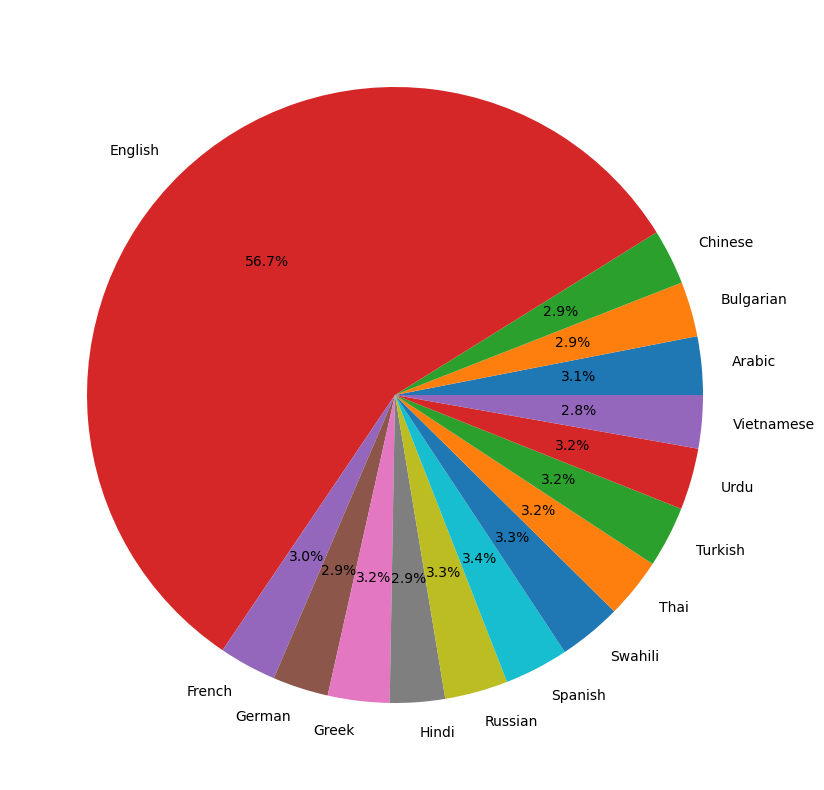

In [30]:
# How are the languages distributed

labels, frequencies = np.unique(test.language.values, return_counts = True)

plt.figure(figsize = (10,10))
plt.pie(frequencies,labels = labels, autopct = '%1.1f%%')
plt.show()

In [31]:
# The language distribution is similar to the train dataset

In [32]:
# Lets generate predictions for test data
predictions = [np.argmax(i) for i in model.predict(test_input)]

163/163 [==============================] - 15s 73ms/step


In [33]:
# Lets put this into the submission format
submission = test.id.copy().to_frame()
submission['prediction'] = predictions

In [34]:
# Check if everything is ok
submission.head()

,id,prediction
0,466ab2432d,0
1,e7ca02b50f,0
2,a19fa9b83e,0
3,6afa181ca6,0
4,e79d56d80c,0


In [35]:
# Save to csv 
submission.to_csv("submission.csv", index = False)